### Problem Statement

Your new target is:
1. 99.4% (this must be consistently shown in your last few epochs, and   not a one-time achievement)

2. Less than or equal to 15 Epochs

3. Less than 10000 Parameters (additional points for doing this in less than 8000 pts)

4. Do this in exactly 3 steps

5. Each File must have "target, result, analysis" TEXT block (either at the start or the end)
  You must convince why have you decided that your target should be what you have decided it to be, and your analysis MUST be correct. 

6. Explain your 3 steps using these target, results, and analysis with links to your GitHub files (Colab files moved to GitHub).

7. Keep Receptive field calculations handy for each of your models. 


### Target:

1. Setting Up the CNN skeleton for the task for of MNIST Classification . The model built should be  lighter in terms of parameters and model is to be trained within 15 Epochs. 

#### Results:
1. Parameters: 10,790k 
2. Best Train Accuracy: 98.88 (11th Epoch)
3. Best Test Accuracy: 98.58 (11th Epoch)
#### Analysis:
1. The Model is overfitting , Efforts can be made to reduce overfitting in the next iteration by adding regularization .
2. Number of parameters could be reduced to handle the overfitting .

### Importing the Relevant Libraries 

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### Data Transformations 

It involves a pipeline of activities such as:
1. Converting the Image data into Tensors.
2. Normalizing the Images 
3. Data Augmentation ( Cropping , Roatating , Scaling )  

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                    #   transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                    #   transforms.Normalize((0.1307,), (0.3081,))
                                       ])


### Dowloading the MNIST Dataset into Test and Train and applying relevant Transforms 

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Creating Data Loader to create batches of images for Training.

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Data Statistics 

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


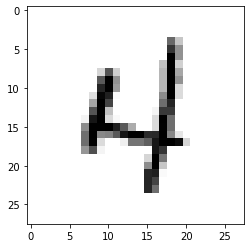

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


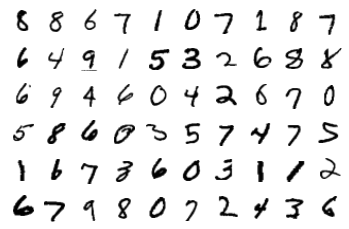

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## CNN Architecture

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Summary 

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 20, 22, 22]           1,800
              ReLU-6           [-1, 20, 22, 22]               0
         MaxPool2d-7           [-1, 20, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             200
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 10, 9, 9]             900
             ReLU-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 20, 7, 7]           1,800
             ReLU-13             [-1, 20, 7, 7]               0
           Conv2d-14             [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.3663163483142853 Batch_id=468 Accuracy=44.04: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]



Test set: Average loss: 0.2110, Accuracy: 9319/10000 (93.19%)

EPOCH: 1


Loss=0.15796847641468048 Batch_id=468 Accuracy=95.45: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]



Test set: Average loss: 0.1037, Accuracy: 9695/10000 (96.95%)

EPOCH: 2


Loss=0.10731173306703568 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]



Test set: Average loss: 0.0735, Accuracy: 9748/10000 (97.48%)

EPOCH: 3


Loss=0.036321643739938736 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]



Test set: Average loss: 0.0764, Accuracy: 9766/10000 (97.66%)

EPOCH: 4


Loss=0.01863623410463333 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:14<00:00, 32.09it/s]



Test set: Average loss: 0.0680, Accuracy: 9785/10000 (97.85%)

EPOCH: 5


Loss=0.042720939964056015 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 32.04it/s]



Test set: Average loss: 0.0611, Accuracy: 9794/10000 (97.94%)

EPOCH: 6


Loss=0.040764305740594864 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]



Test set: Average loss: 0.0520, Accuracy: 9818/10000 (98.18%)

EPOCH: 7


Loss=0.027243899181485176 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]



Test set: Average loss: 0.0600, Accuracy: 9823/10000 (98.23%)

EPOCH: 8


Loss=0.014839675277471542 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]



Test set: Average loss: 0.0508, Accuracy: 9842/10000 (98.42%)

EPOCH: 9


Loss=0.019802216440439224 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]



Test set: Average loss: 0.0455, Accuracy: 9847/10000 (98.47%)

EPOCH: 10


Loss=0.02676772139966488 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]



Test set: Average loss: 0.0475, Accuracy: 9850/10000 (98.50%)

EPOCH: 11


Loss=0.058135341852903366 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]



Test set: Average loss: 0.0443, Accuracy: 9858/10000 (98.58%)

EPOCH: 12


Loss=0.04658126458525658 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]



Test set: Average loss: 0.0454, Accuracy: 9857/10000 (98.57%)

EPOCH: 13


Loss=0.023402348160743713 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 32.23it/s]



Test set: Average loss: 0.0463, Accuracy: 9854/10000 (98.54%)

EPOCH: 14


Loss=0.017864247784018517 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]



Test set: Average loss: 0.0497, Accuracy: 9854/10000 (98.54%)



## Model evaluation Metrics : Loss and Accuracy 

Text(0.5, 1.0, 'Test Accuracy')

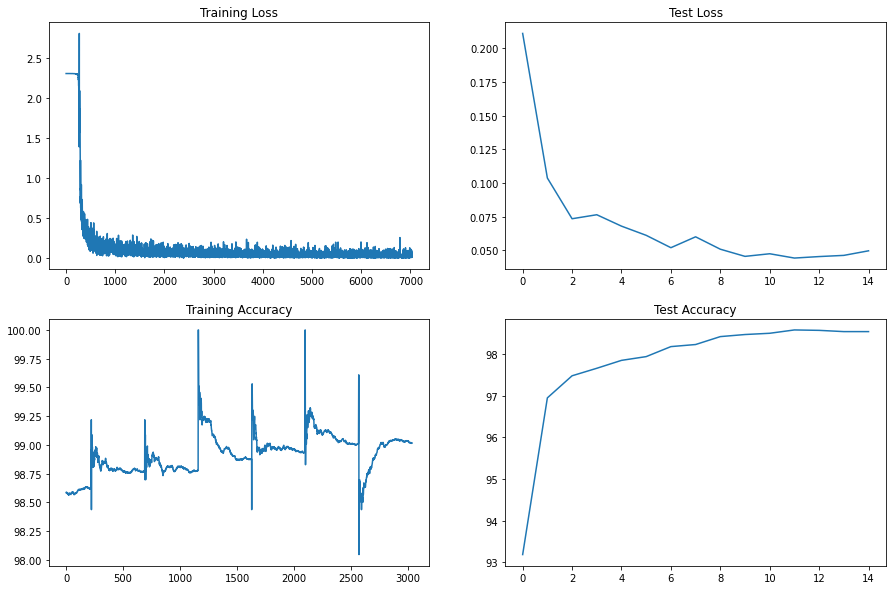

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")